# The Condorcet Jury Theorem

In [72]:
import random
import pylab
import matplotlib.mlab as mlab
import functools
import itertools
from __future__ import print_function
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
from functools import reduce
from collections import Counter
from tqdm.notebook import tqdm  

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, Math, Latex
sns.set()

Suppose that $V=\{1, 2, 3, \ldots, n\}$ is a set of voters or experts, and consider a  set of two alternatives.  E.g., $\{\mbox{convict}, \mbox{acquit}\}$, $\{\mbox{abolish}, \mbox{keep}\}$, $\{0,1\}$, $\ldots$

Let  $\mathbf{x}$ be a random variable (called the **state**)  whose values range over the two alternatives. 

In addition, let $\mathbf{v}_1, \mathbf{v}_2, \ldots$ be random variables represeting the votes for individuals $1, 2, \ldots, n$

Let $C_i$ be the event that $i$ votes correctly: it is  the event that $v_i$ coincides with the state. 

**Unconditional independence (UI)**: The correctness events $C_1, C_2, \ldots, C_n$ are (unconditionally) independent.

**Unconditional competence (UC)**: The (unconditional) correctness probability
$p = Pr(C_i)$, the (unconditional) competence, (i) exceeds $\frac{1}{2}$ and (ii) is the same for
each voter $i$.

**Condorcet Jury Theorem**. Assume UI and UC. As the group size increases, the probability of a
correct majority (i) increases (growing reliability), and (ii) tends to one (infallibility).

The Condorcet Jury Theorem has two main theses: 
    
**The growing-reliability thesis**: Larger groups are better truth-trackers. That
is, they are more likely to select the correct alternative (by majority) than
smaller groups or single individuals.

**The infallibility thesis**: Huge groups are *infallible* truth-trackers. That is, the
likelihood of a correct (majority) decision tends to full certainty as the group
becomes larger and larger.

The probability of at least $m$ voters being correct is: 

$$\sum_{h=m}^n \frac{n!}{h!(n-h)!} * p^h*(1-p)^{n-h}$$


In [73]:
import operator as op
def ncr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, range(n, n-r, -1))
    denom = reduce(op.mul, range(1, r+1))
    return float(numer//denom)

def probability_majority_is_correct(num_voters=100,prob=0.51):
    return sum([ncr(num_voters,k)*(prob**k)*(1-prob)**(num_voters-k) 
                for k in range(int(num_voters/2+1),num_voters+1)])

In [74]:
def make_maj_prob_graphs():
    probs = np.linspace(0,1,num=100)

    number_of_voters = [ 1, 3,  11, 51,  201, 501, 1001]
    sns.set(rc={'figure.figsize':(10,5)})
    
    plt.subplot(121)
    for num_voters in number_of_voters:
        maj_probs = [probability_majority_is_correct(num_voters=num_voters,prob=p)  for p in probs]
        plt.plot(list(probs),maj_probs, label="$n=" + str(num_voters) + "$")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Probability of voting correctly')
    plt.ylabel('Probability the majority is correct')
    
    plt.subplot(122)
    for num_voters in number_of_voters:
        maj_probs = [probability_majority_is_correct(num_voters=num_voters,prob=p) - p  for p in probs]
        plt.plot(list(probs),maj_probs, label="$n=" + str(num_voters) + "$")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Probability of voting correctly')
    plt.ylabel('$Pr(M_n) - p$')

    plt.plot([0.0,1.0],[0.0,0.0],color='black',alpha=0.6)
    
    sns.set()
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)

    plt.savefig('cjtplots.png')


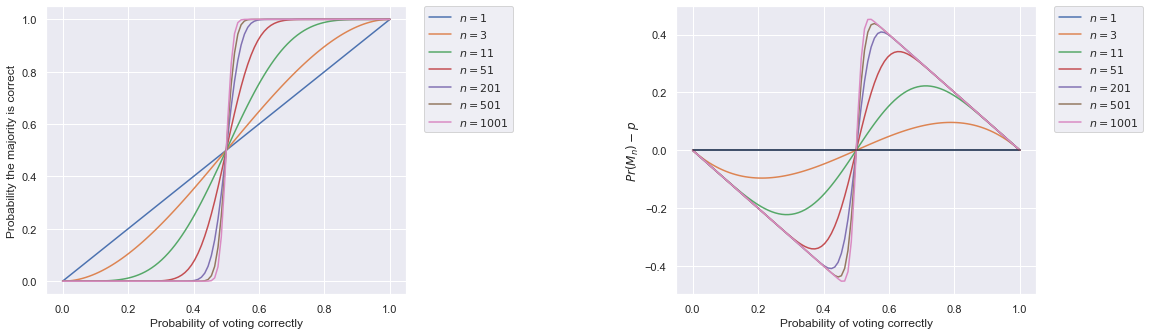

In [75]:
make_maj_prob_graphs()

In [76]:
evidence = [2,3,4,5,6,7,8,10, 12, 14]

class CJTAgent():
    
    def __init__(self, comp=0.501):
        self.comp = comp
        
    def vote(self, ev):
        #vote on whether the event is true or false
        #need the actual truth value in order to know which direction to be biased
        if ev:
            #ev is true
            return int(random.random() < self.comp)
        else:
            return 1 - int(random.random() < self.comp)


def maj_vote(the_votes):
    votes_true = len([v for v in the_votes if v == 1])
    votes_false = len([v for v in the_votes if v == 0])

    if votes_true > votes_false:
        return 1
    elif votes_false > votes_true:
        return 0
    else:
        return -1  #tied

def generate_competences(n, mu=0.51, sigma=0.2):
    competences = list()
    for i in range(0,n):
        #sample a comp until you find one between 1 and 0
        comp=np.random.normal(mu, sigma)
    
        while comp > 1.0 or comp < 0.0:
            comp=np.random.normal(mu, sigma)
        competences.append(comp)
    return competences

In [77]:
import pandas as pd
NUM_ROUNDS = 500
from tqdm import notebook 

def make_plots(max_voters=201, 
               comp_mu=0.501, 
               comp_sigma=0.1):
    P=True
    max_num_voters = max_voters
    total_num_voters = range(1,max_num_voters)

    competences = generate_competences(max_num_voters,
                                       mu=comp_mu, 
                                       sigma=comp_sigma)
    maj_probs = list()
    expert_probs = list()
    for num_voters in notebook.tqdm(total_num_voters, desc='voting'):
        experts = list()

        experts = [CJTAgent(comp=competences[num-1]) for num in range(0,num_voters)]
    
        maj_votes = list()
        expert_votes = list()
        for r in range(0,NUM_ROUNDS):
            # everyone votes
            votes = [a.vote(P) for a in experts]
            maj_votes.append(maj_vote(votes))
        
            expert_votes.append(random.choice(experts).vote(P))
    
        maj_probs.append(float(float(len([v for v in maj_votes if v==1]))/float(len(maj_votes))))
        expert_probs.append(float(len([v for v in expert_votes if v==1]))/float(len(expert_votes)))
    
    sns.set(rc={'figure.figsize':(11,5)})
    plt.subplot(121)

    data = {" ": range(0,max_num_voters), "competence": competences}
    plt.ylim(0,1.05)
    plt.title("Competences")
    df = pd.DataFrame(data=data)
    sns.regplot(x=" ", y="competence", data=df, color=sns.xkcd_rgb["pale red"])


    plt.subplot(122)
    plt.title("Majority vs. Experts")
    plt.plot(list(total_num_voters), maj_probs, label="majority ")
    plt.plot(list(total_num_voters), expert_probs, label="expert ")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Number of experts')
    plt.ylabel('Probability')
    plt.ylim(0,1.05)
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)

    sns.set()
    plt.savefig("cjt_simulation.png")




In [78]:
p = interact_manual(make_plots,max_voters=(1,501,1),comp_mu=(0,1,0.01),comp_sigma=(0,2,0.1))

interactive(children=(IntSlider(value=201, description='max_voters', max=501, min=1), FloatSlider(value=0.501,…

## Further Reading 

D. Austen-Smith and J. Banks, Aggregation, Rationality and the Condorcet Jury Theorem, The American Political Science Review, 90, 1, pgs. 34 - 45, 1996
 
D. Estlund, Opinion Leaders, Independence and Condorcet's Jury Theorem, Theory and Decision, 36, pgs. 131 - 162, 1994
 
F. Dietrich, The premises of Condorcet's Jury Theorem are not simultaneously justified, Episteme, Episteme - a Journal of Social Epistemology 5(1): 56-73, 2008

R. Goodin and K. Spiekermann, *An Epistemic Theory of Democracy*, Oxford University Press, 2018
 

What happens if there are more than two options? 

C. List and R. Goodin. Epistemic democracy: Generalizing the condorcet jury theorem. Journal of
political philosophy, 9(3):277–306, 2001.

**Theorem** (List and Goodin).

1. Suppose that there are $k$ options and that each voter/juror has independent probabilities $p_1, \ldots, p_k$ of voting for options $1, \ldots, k$, respectively, where the probability $p_i$ of voting for the "correct" option $i$ exceeds the probabilities $p_j$ of voting for any of the "wrong" outcomes $j\ne i$.    Then, the "correct" option is more likely than any other option to be the plurality winner. 

2. As the number of voters/jurors tends to infinity, the probability of the "correct" option being the plurality winner converges to 1. 



In [79]:
def display_probs(cjt_model, num_options):
    '''display the probabilities of the agents'''
    _probs = list()
    for a in cjt_model.schedule.agents: 
        _probs.append(np.array(a.probs))
    probs = np.array(_probs)
    prs = probs.transpose()

    for opt in range(num_options):
        plt.barh(range(num_agents), prs[opt], 1,
                 left=sum([np.array([0.0]*num_agents)] + [prs[i] for i in range(opt)]),
                  lw = 0.01)
    plt.show()
    plt.clf()

In [80]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Options:
    '''Options is a list with one option identified as the "correct" one '''
    num: int = 2
    correct_idx: int = 0 # index of the correct option
    names:  List[str] = field(default_factory=list) # names of the options
        
    def __post_init__(self):
        self.names = [f"P{p+1}" for p in self.props]
    
    @property
    def props(self) -> List[int]:
        '''the list of all options'''
        return list(range(self.num))
    
    @property
    def C(self) -> int:
        return self.props[self.correct_idx]
    
    @property
    def C_as_list(self) -> List[int]:
        return [self.props[self.correct_idx]]
    
    @property
    def W(self) -> List[int]: 
        return list(self.props[self.correct_idx + 1::])
    
    def name(self, opt): 
        return self.names[opt]
    
    def set_names(self, names):
        assert len(names) == self.num, f"You need {self.num} names, but only provided {len(names)} names: {names}"
        self.names = names
        
    # make options iterable
    def __iter__(self):
        return iter(self.props)


In [81]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector


def gen_option_probability_normal(mu,sigma):
    '''return single p'''
    pr=np.random.normal(mu, sigma)
    while pr > 1.0 or pr < 0.0:
        pr=np.random.normal(mu, sigma)
    return [pr, 1-pr]

def gen_option_probability_beta(a,b, num=1):
    pr=np.random.beta(a,b, num)[0]
    return [pr, 1-pr]

def gen_options_probability_dirichlet(params, num=1):
    return np.random.dirichlet(params, num)
    

init_probs = {'1_opt_fixed_probs1': lambda : [0.51, 0.49],
              '1_opt_fixed_probs2': lambda : [0.75, 0.25],
              '1_opt_fixed_probs3': lambda : [0.49, 0.51],
              '4_opt_fixed_probs': lambda : [0.40, 0.20, 0.20, 0.20],
              '7_opt_fixed_probs': lambda : [0.30, 0.10, 0.20, 0.05, 0.05, 0.15, 0.15],
              '2_opt_normal1': lambda : gen_option_probability_normal(0.51, 0.1),
              '2_opt_normal2': lambda : gen_option_probability_normal(0.6, 0.25),
              '2_opt_normal3': lambda : gen_option_probability_normal(0.6, 0.1),
              '2_opt_beta1': lambda : gen_option_probability_beta(20,20),
              '2_opt_beta2': lambda : gen_option_probability_beta(21,20),
              '2_opt_beta3': lambda : gen_option_probability_beta(15,20),
              '4_opt_dirichlet1': lambda : gen_options_probability_dirichlet((2, 1, 1, 1))[0],
              '4_opt_dirichlet2': lambda : gen_options_probability_dirichlet((1.15, 1, 1, 1))[0],
              '4_opt_dirichlet3': lambda : gen_options_probability_dirichlet((4,3,2,1))[0],
             }


def plurality_vote(votes):
    tally  = Counter(votes)
    max_plurality_score = max(tally.values())
    winners = [o for o in tally.keys() if tally[o] == max_plurality_score]
    return winners 

def percent_plurality_vote_correct(model):
    num_correct = 0
    for r in range(model.num_rounds):
        winners = plurality_vote([a.vote() for a in model.schedule.agents])
        if len(winners) == 1 and model.options.C == winners[0]:
            num_correct += 1
    return float(num_correct) / model.num_rounds

def percent_expert_correct(model):
    num_correct = 0
    for r in range(model.num_rounds):
        expert = random.choice(model.schedule.agents)
        if  model.options.C == expert.vote():
            num_correct += 1
    return float(num_correct) / model.num_rounds


class Expert(Agent):
    """Expert to vote on a single proposition.
    competence: float between 0 and 1"""
    def __init__(self, unique_id, model, options, probs):
        super().__init__(unique_id, model)
        self.options = options
        self.probs = probs
        
    def vote(self):
        return np.random.choice(self.options, 1, p=self.probs)[0]
    
    def step(self):
        self.vote()
        #print(self.unique_id, self.selected_option)
    
class CJTModel(Model):
    """A model with some number of experts."""
    def __init__(self, N, num_rounds, gen_prob, num_options=2):
        self.num_experts = N
        self.options = Options(num_options)
        self.schedule = RandomActivation(self)
        self.num_rounds = num_rounds
        
        # Create experts
        for i in range(self.num_experts):
            a = Expert(i, self, self.options.props, gen_prob())
            self.schedule.add(a) 
        
        self.datacollector = DataCollector(
            model_reporters={"PercentPluralityCorrect": percent_plurality_vote_correct,
                             "PercentExpertCorrect": percent_expert_correct})
    
    def run(self):
        '''run simulation.'''
        
        self.schedule.step()
        self.datacollector.collect(self)



In [82]:
def display_plots(plot_type):
    
    max_num_agents = 75
    
    num_options = int(plot_type.split("_")[0]) 
    num_rounds = 500

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)
    perc_plurality_correct = list()
    perc_expert_correct = list()
    for num_agents in tqdm(range(1,max_num_agents+1)): 
        cjt_model = CJTModel(num_agents, 
                             num_rounds, 
                             init_probs[plot_type], 
                             num_options=num_options)
        cjt_model.run()
        winners = cjt_model.datacollector.get_model_vars_dataframe()
        perc_plurality_correct.append(winners.PercentPluralityCorrect.values[0])
        perc_expert_correct.append(winners.PercentExpertCorrect.values[0])
        
    _probs = list()
    for a in cjt_model.schedule.agents: 
        _probs.append(np.array(a.probs))
    probs = np.array(_probs)
    prs = probs.transpose()

    for opt in range(num_options):
        ax1.barh(range(num_agents), prs[opt], 1,
                 left=sum([np.array([0.0]*num_agents)] + [prs[i] for i in range(opt)]),
                  lw = 0.01)
    ax2.plot(range(1,max_num_agents+1), perc_plurality_correct, label="Plurality")
    ax2.plot(range(1,max_num_agents+1), perc_expert_correct, label="Expert")
    
    plt.legend(bbox_to_anchor=(1.25,0.5))
    plt.savefig("plurality_example.pdf")
    #plt.show()
    

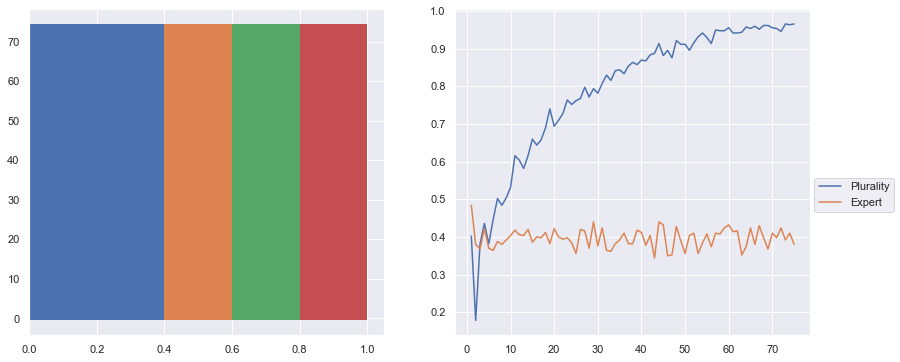

In [57]:
display_plots('4_opt_fixed_probs')

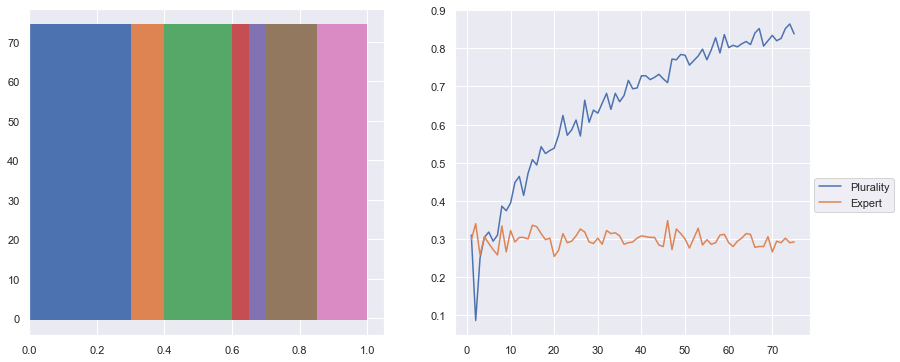

In [58]:
display_plots('7_opt_fixed_probs')

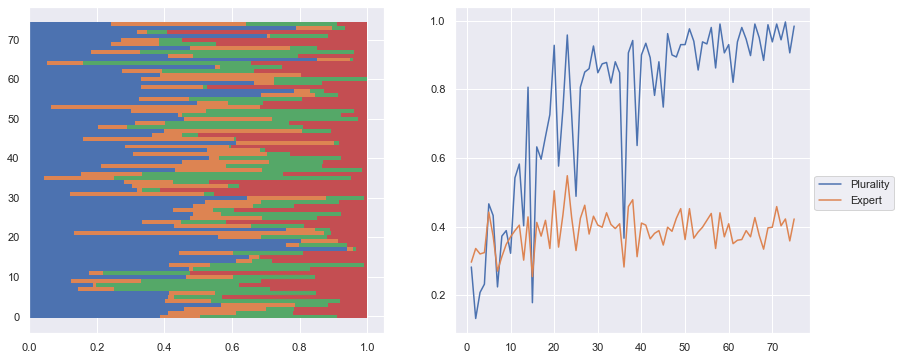

In [59]:
display_plots('4_opt_dirichlet1')

In [60]:

p=interact_manual(display_plots,plot_type=widgets.Dropdown(
    options=[
        ('4 Options', '4_opt_fixed_probs'), 
        ('7 Options', '7_opt_fixed_probs'), 
        ('4 Options Random Competence 1', '4_opt_dirichlet1'),
        ('4 Options Random Competence 2', '4_opt_dirichlet2'),
        ('4 Options Random Competence 3', '4_opt_dirichlet3'), 
        ('1 Option Random Competence 1', '2_opt_beta1'),
        ('1 Option Random Competence 2', '2_opt_beta2'),
        ('1 Option Random Competence 3', '2_opt_beta3'),
        ('1 Option Random Competence 4', '2_opt_normal1'),
        ('1 Option Random Competence 5', '2_opt_normal2'),
        ('1 Option Random Competence 6', '2_opt_normal3'),

    ],
    value='4_opt_fixed_probs',
    description='Simulation:'))

interactive(children=(Dropdown(description='Simulation:', options=(('4 Options', '4_opt_fixed_probs'), ('7 Opt…

## Further Reading

1. U. Hahn, M. von Sydow and C. Merdes (2018). [How Communication Can Make Voters Choose Less Well](https://onlinelibrary.wiley.com/doi/epdf/10.1111/tops.12401), Topics in Cognitive Science

2. F. Dietrich and K. Spiekermann (2020). [Jury Theorems: a review](http://www.franzdietrich.net/Papers/DietrichSpiekermann-JuryTheorems.pdf),  In: M. Fricker et al. (eds.) The Routledge Handbook of Social Epistemology. New York and Abingdon: Routledge

## Grading Jury Theorem

Michael Morreau (2020). [Democracy without Enlightenment: A Jury Theorem for Evaluative Voting](https://onlinelibrary.wiley.com/doi/full/10.1111/jopp.12226), The Journal of Political Philosophy, 2020, pp. 1 - 23


Suppose that there are $n$ members of a groiup that are *grading* an item $x$ in some language of grades.  Exactly one grade in this language is the *right grade* for $x$ (in some suitably decision-independent sense).  

Let $P_n$ be the probability that the *median* of the grades for $x$ assigned by the members of the group. 

Let $p$ be the probability that an individual assigns the correct grade to item $x$

Let $o$ be the probability that an individual assigns either the right grade or a lower one. 

Let $q$ be the probability that an individual assigns either the right grade or a higher one. 

Suppose that these probabilities are the same for each individual. 

**Grading Jury Theorem** (Morreau) If $|o-q| < p < 1$ then

1. The larger the number $n$ of members, the higher is $P_n$, and 
2. $P_n$ can be brought arbitrarily close to $1$ by increasing $n$. 


In [61]:
grades = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

correct_grade = 3

class Grader():
    
    def __init__(self, grades, comp=(0.45, 0.15, 0.40)):
        too_low, correct, too_high = comp
        self.grades = grades
        self.comp_too_low = too_low
        self.comp_correct = correct
        self.comp_too_high = too_high
        
    def grade(self, true_grade):

        grades = {
            "L": [g for g in self.grades if g < true_grade],
            "C": [g for g in self.grades if g == true_grade],
            "H": [g for g in self.grades if g > true_grade]
        }
        
        if len(grades["L"]) == 0: 
            grades["L"] = grades["C"]
        elif len(grades["H"]) == 0:
            grades["H"] = grades["C"]

        g_type = random.choices(["L", "C", "H"], 
                                weights=(self.comp_too_low, self.comp_correct, self.comp_too_high))[0]

        return random.choice(grades[g_type])

def median_grade(the_grades): 
    
    return np.median(the_grades)
    
def mean_grade(the_grades): 
    
    return np.mean(the_grades)

def maj_vote(the_votes):
    votes_true = len([v for v in the_votes if v == 1])
    votes_false = len([v for v in the_votes if v == 0])

    if votes_true > votes_false:
        return 1
    elif votes_false > votes_true:
        return 0
    else:
        return -1  #tied



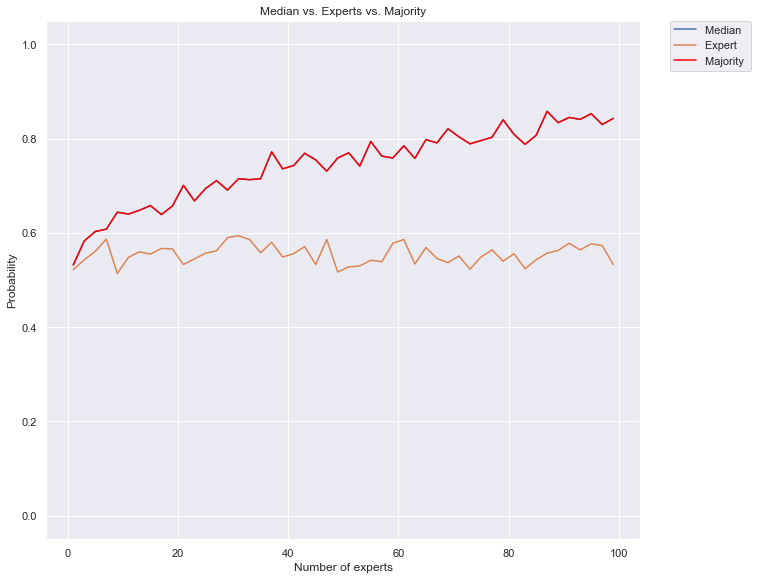

In [62]:
grades = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

correct_grade = 5.0

comp_too_low = 0.45
comp_correct = 0.15
comp_too_high = 0.4 

# comp_too_low = 0.3
# comp_correct = 0.55
# comp_too_high = 0.15 

# comp_too_low = 0.3
# comp_correct = 0.1
# comp_too_high = 0.6 

num_rounds = 1000

max_num_voters = 100


median_probs = list()
expert_probs = list()
majority_probs = list()
    
sns.set(rc={'figure.figsize':(6,9)})

for num_voters in notebook.tqdm(range(1,max_num_voters,2), desc='voting'):
    #print(num_voters)
    
    graders = [Grader(grades, comp = (comp_too_low, comp_correct, comp_too_high)) for _ in range(num_voters)]
    
    median_grades = list()
    expert_grades = list()
    majority_votes = list()
    for r in range(num_rounds): 
        
        the_grades = [g.grade(correct_grade) for g in graders]
        the_votes = [g == correct_grade for g in the_grades]
        median_grades.append(median_grade(the_grades))
        
        majority_votes.append(maj_vote(the_votes))
        expert_grades.append(random.choice(graders).grade(correct_grade))
        
    #print(median_grades)
    median_probs.append(float(len([g for g in median_grades if g == correct_grade])) / float(len(median_grades)))
    expert_probs.append(float(len([g for g in expert_grades if g == correct_grade])) / float(len(expert_grades)))
    majority_probs.append(float(len([g for g in majority_votes if g == 1])) / float(len(majority_votes)))
    

plt.title("Median vs. Experts vs. Majority")
plt.plot(list(range(1,max_num_voters,2)), median_probs, label="Median ")
plt.plot(list(range(1,max_num_voters,2)), expert_probs, label="Expert ")
plt.plot(list(range(1,max_num_voters,2)), majority_probs, color="red", label="Majority ")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of experts')
plt.ylabel('Probability')
plt.ylim(-0.05,1.05)
plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)

    
    


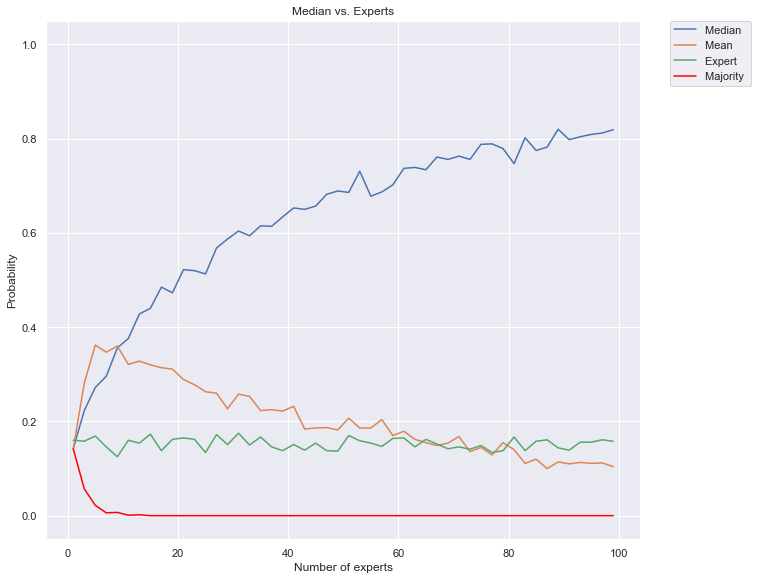

In [63]:
grades = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

correct_grade = 4.0

comp_too_low = 0.45
comp_correct = 0.15
comp_too_high = 0.4 

# comp_too_low = 0.3
# comp_correct = 0.5
# comp_too_high = 0.2 

# comp_too_low = 0.3
# comp_correct = 0.1
# comp_too_high = 0.6 

num_rounds = 1000

max_num_voters = 100


median_probs = list()
expert_probs = list()
mean_probs = list()
majority_probs = list()
    
sns.set(rc={'figure.figsize':(6,9)})

for num_voters in notebook.tqdm(range(1,max_num_voters,2), desc='voting'):
    #print(num_voters)
    
    graders = [Grader(grades, comp = (comp_too_low, comp_correct, comp_too_high)) for _ in range(num_voters)]
    
    median_grades = list()
    mean_grades = list()
    expert_grades = list()
    majority_votes = list()
    for r in range(num_rounds): 
        
        the_grades = [g.grade(correct_grade) for g in graders]
        the_votes = [g == correct_grade for g in the_grades]
        median_grades.append(median_grade(the_grades))
        mean_grades.append(mean_grade(the_grades))
        
        majority_votes.append(maj_vote(the_votes))
        expert_grades.append(random.choice(graders).grade(correct_grade))
        
    #print(median_grades)
    median_probs.append(float(len([g for g in median_grades if g == correct_grade])) / float(len(median_grades)))
    mean_probs.append(float(len([g for g in mean_grades if round(g, 0) == correct_grade])) / float(len(mean_grades)))
    expert_probs.append(float(len([g for g in expert_grades if g == correct_grade])) / float(len(expert_grades)))
    majority_probs.append(float(len([g for g in majority_votes if g == 1])) / float(len(majority_votes)))
    

plt.title("Median vs. Experts")
plt.plot(list(range(1,max_num_voters,2)), median_probs, label="Median ")
plt.plot(list(range(1,max_num_voters,2)), mean_probs, label="Mean ")
plt.plot(list(range(1,max_num_voters,2)), expert_probs, label="Expert ")
plt.plot(list(range(1,max_num_voters,2)), majority_probs, color="red", label="Majority ")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of experts')
plt.ylabel('Probability')
plt.ylim(-0.05,1.05)
plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)

    
    


In [83]:
def generate_competences(num_experts, mu = 0.15, sigma = 0.1, min_bias = 0.25, max_bias = 0.75):
    
    # sample competence
    competences = list()
    
    for i in range(0,num_experts):
        #sample a comp until you find one between 1 and 0
        comp=np.random.normal(mu, sigma)
    
        while comp > 1.0 or comp < 0.0:
            comp=np.random.normal(mu, sigma)
        
        wrong = 1 - comp
        
        bias = np.random.uniform(min_bias, max_bias)
        too_low = wrong * bias
        
        too_high = wrong * (1 - bias)
        competences.append((too_low, comp, too_high))
        
        
    return competences
        

In [84]:
num_rounds = 1000

max_num_voters = 100


def make_plots_grader2(max_num_voters=100, 
                       correct_grade = 3.0,
                       mean=0.15,
                       std=0.1,
                       min_bias = 0.25,
                       max_bias = 0.75):


    median_probs = list()
    mean_probs = list()
    expert_probs = list()
    majority_probs = list()


    competences = generate_competences(max_num_voters, 
                                       mu = mean, 
                                       sigma = std, 
                                       min_bias = min_bias, 
                                       max_bias = max_bias)
    #print(competences)
    for num_voters in notebook.tqdm(range(1, max_num_voters, 2), desc='voting'):
        #print(num_voters)

        graders = [Grader(grades, comp = competences[_]) for _ in range(num_voters)]

        median_grades = list()
        mean_grades = list()
        expert_grades = list()
        majority_votes = list()
        for r in range(num_rounds): 

            the_grades = [g.grade(correct_grade) for g in graders]
            the_votes = [g == correct_grade for g in the_grades]
            median_grades.append(median_grade(the_grades))
            mean_grades.append(mean_grade(the_grades))

            majority_votes.append(maj_vote(the_votes))
            expert_grades.append(random.choice(graders).grade(correct_grade))

        #print(median_grades)
        median_probs.append(float(len([g for g in median_grades if g == correct_grade])) / float(len(median_grades)))
        mean_probs.append(float(len([g for g in mean_grades if round(g, 0) == correct_grade])) / float(len(mean_grades)))
        expert_probs.append(float(len([g for g in expert_grades if g == correct_grade])) / float(len(expert_grades)))
        majority_probs.append(float(len([g for g in majority_votes if g == 1])) / float(len(majority_votes)))

    fig, axs = plt.subplots(ncols=2, figsize=(14, 7), sharex=True, sharey=False)

    data = {"Voter": range(0,max_num_voters),  "too_low": [c[0] for c in competences], "correct": [c[1] for c in competences], "too_high": [c[2] for c in competences]}
    axs[0].set_ylim(0,1.05)
    axs[0].set_title("Competences")
    df = pd.DataFrame(data=data)
    sns.regplot(x="Voter", y="correct", data=df, color=sns.xkcd_rgb["pale red"], label="Correct", ax = axs[0])
    sns.regplot(x="Voter", y="too_low", data=df, color=sns.xkcd_rgb["blue"], label="Too Low", ax = axs[0])
    sns.regplot(x="Voter", y="too_high", data=df, color=sns.xkcd_rgb["green"], label="Too High", ax = axs[0])
    axs[0].set_ylabel(" ")
    axs[0].legend(loc="upper center",ncol=3)


    axs[1].set_title("Median vs. Experts")
    axs[1].plot(list(range(1,max_num_voters,2)), median_probs, label="Median ")
    axs[1].plot(list(range(1,max_num_voters,2)), mean_probs, label="Mean ")
    axs[1].plot(list(range(1,max_num_voters,2)), expert_probs, label="Expert ")
    axs[1].plot(list(range(1,max_num_voters,2)), majority_probs, color="red", label="Majority ")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[1].set_xlabel('Number of experts')
    axs[1].set_ylabel('Probability')
    axs[1].set_ylim(-0.05,1.05)
    #plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)
    plt.show()
    
    


In [85]:
p = interact_manual(make_plots_grader2,
                    max_num_voters=(1,200,1),
                    correct_grade = (0.0,5.0,1),
                    mean=(0,1,0.01),
                    std=(0,2,0.1),
                    min_bias = (0.0,1.0,0.1),
                    max_bias = (0.0, 1.0, 0.1))

interactive(children=(IntSlider(value=100, description='max_num_voters', max=200, min=1), FloatSlider(value=3.…

In [86]:
def generate_competences2(num_experts, params = (1, 1, 1)):
    
    return [tuple(np.random.dirichlet(params)) for _ in range(num_experts)]


In [87]:
num_rounds = 1000

max_num_voters = 100


def make_plots_grader3(max_num_voters=100,
                       correct_grade = 3.0,
                       too_low=1,
                       correct=1,
                       too_high = 1):


    median_probs = list()
    mean_probs = list()
    expert_probs = list()
    majority_probs = list()


    competences = generate_competences2(max_num_voters,
                                        params = (too_low, correct, too_high))
    #print(competences)
    for num_voters in notebook.tqdm(range(1, max_num_voters, 2), desc='voting'):
        #print(num_voters)

        graders = [Grader(grades, comp = competences[_]) for _ in range(num_voters)]

        median_grades = list()
        mean_grades = list()
        expert_grades = list()
        majority_votes = list()
        for r in range(num_rounds): 

            the_grades = [g.grade(correct_grade) for g in graders]
            the_votes = [g == correct_grade for g in the_grades]
            median_grades.append(median_grade(the_grades))
            mean_grades.append(mean_grade(the_grades))

            majority_votes.append(maj_vote(the_votes))
            expert_grades.append(random.choice(graders).grade(correct_grade))

        #print(median_grades)
        median_probs.append(float(len([g for g in median_grades if g == correct_grade])) / float(len(median_grades)))
        mean_probs.append(float(len([g for g in mean_grades if round(g, 0) == correct_grade])) / float(len(mean_grades)))
        expert_probs.append(float(len([g for g in expert_grades if g == correct_grade])) / float(len(expert_grades)))
        majority_probs.append(float(len([g for g in majority_votes if g == 1])) / float(len(majority_votes)))

    fig, axs = plt.subplots(ncols=2, figsize=(14, 7), sharex=True, sharey=False)

    data = {"Voter": range(0,max_num_voters),  "too_low": [c[0] for c in competences], "correct": [c[1] for c in competences], "too_high": [c[2] for c in competences]}
    axs[0].set_ylim(0,1.05)
    axs[0].set_title("Competences")
    df = pd.DataFrame(data=data)
    sns.regplot(x="Voter", y="correct", data=df, color=sns.xkcd_rgb["pale red"], label="Correct", ax = axs[0])
    sns.regplot(x="Voter", y="too_low", data=df, color=sns.xkcd_rgb["blue"], label="Too Low", ax = axs[0])
    sns.regplot(x="Voter", y="too_high", data=df, color=sns.xkcd_rgb["green"], label="Too High", ax = axs[0])
    axs[0].set_ylabel(" ")
    axs[0].legend(loc="upper center",ncol=3)


    axs[1].set_title("Median vs. Experts")
    axs[1].plot(list(range(1,max_num_voters,2)), median_probs, label="Median ", linewidth=2)
    axs[1].plot(list(range(1,max_num_voters,2)), mean_probs, label="Mean ")
    axs[1].plot(list(range(1,max_num_voters,2)), expert_probs, label="Expert ")
    axs[1].plot(list(range(1,max_num_voters,2)), majority_probs, color="red", label="Majority ")
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[1].set_xlabel('Number of experts')
    axs[1].set_ylabel('Probability')
    axs[1].set_ylim(-0.05,1.05)
    #plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9, wspace = 0.75)
    plt.show()
    
    


In [88]:
p = interact_manual(make_plots_grader3,
                    max_num_voters=(1,200,1),
                    correct_grade = (0.0,5.0,1),
                    too_low=(1,10),
                    correct=(1,10),
                    too_high=(1,10))

interactive(children=(IntSlider(value=100, description='max_num_voters', max=200, min=1), FloatSlider(value=3.…